# Welcome to the Lab 🥼🧪
## Which metros have the highest share of mom and pop ownership? Institutional Ownership? 

**Note** This notebook will work with any of the 70k+ markets supported by the Parcl Labs API.

As a reminder, you can get your Parcl Labs API key [here](https://dashboard.parcllabs.com/signup) to follow along. 

To run this immediately, you can use Google Colab. Remember, you must set your `PARCL_LABS_API_KEY` as a secret. See this [guide](https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75) for more information.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ParclLabs/parcllabs-examples/blob/main/python/table_of_mom_and_pop_vs_institutions_ownership.ipynb)

We will be creating this table: 

![Chart](assets/top100_metros_mom_and_pops.png)

In [1]:
# Environment setup
import os
import sys
import subprocess
from datetime import datetime

# Collab setup from one click above
if "google.colab" in sys.modules:
    from google.colab import userdata
    %pip install parcllabs plotly kaleido
    api_key = userdata.get('PARCL_LABS_API_KEY')
else:
    api_key = os.getenv('PARCL_LABS_API_KEY')

In [7]:
import parcllabs
import pandas as pd
import plotly.express as px
from parcllabs import ParclLabsClient

print(f"Parcl Labs Version: {parcllabs.__version__}")

Parcl Labs Version: 0.1.18


In [19]:
# instantiate the client
client = ParclLabsClient(api_key=api_key, limit=1)

In [21]:
# lets get all metros in the country
metros = client.search_markets.retrieve(
    location_type='CBSA',
    as_dataframe=True,
    params={
        'limit': 100
    },
    sort_by='TOTAL_POPULATION',
    sort_order='DESC'
)

In [23]:
# get the ids
metro_ids = metros['parcl_id'].tolist()
len(metro_ids)

100

In [25]:
# get most recent housing stock for all metros
# lets retrieve the portfolio size ownership metrics
ports = client.portfolio_metrics_sf_housing_stock_ownership.retrieve_many(
    parcl_ids=metro_ids,
    as_dataframe=True,
    
)

ports.head()

|████████████████████████████████████████| 100/100 [100%] in 15.9s (6.28/s) 


,date,count_portfolio_2_to_9,count_portfolio_10_to_99,count_portfolio_100_to_999,count_portfolio_1000_plus,count_all_portfolios,pct_sf_housing_stock_portfolio_2_to_9,pct_sf_housing_stock_portfolio_10_to_99,pct_sf_housing_stock_portfolio_100_to_999,pct_sf_housing_stock_portfolio_1000_plus,pct_sf_housing_stock_all_portfolios,parcl_id
0,2024-03-01,135863,7295,1033,1998,146189,4.85,0.26,0.04,0.07,5.22,2900187
1,2024-03-01,194888,10628,861,4339,210716,9.76,0.53,0.04,0.22,10.55,2900078
2,2024-03-01,97120,16037,2857,10664,126678,4.81,0.79,0.14,0.53,6.28,2899845
3,2024-03-01,154043,27263,3125,30298,214729,8.02,1.42,0.16,1.58,11.18,2899734
4,2024-03-01,142690,18455,2118,23161,186424,8.08,1.05,0.12,1.31,10.56,2899967


In [91]:
# grab columns we want
out = pd.merge(ports, metros, on='parcl_id')
cols = [
    'name',
    'pct_sf_housing_stock_portfolio_2_to_9', 
    'pct_sf_housing_stock_portfolio_10_to_99', 
    'pct_sf_housing_stock_portfolio_100_to_999',
    'pct_sf_housing_stock_portfolio_1000_plus',
    'pct_sf_housing_stock_all_portfolios'
]
out = out[cols]

# divide by 100 for charting
# out['pct_sf_housing_stock_portfolio_2_to_9'] = out['pct_sf_housing_stock_portfolio_2_to_9']/100
# out['pct_sf_housing_stock_portfolio_10_to_99'] = out['pct_sf_housing_stock_portfolio_10_to_99']/100
# out['pct_sf_housing_stock_portfolio_100_to_999'] = out['pct_sf_housing_stock_portfolio_100_to_999']/100
# out['pct_sf_housing_stock_portfolio_1000_plus'] = out['pct_sf_housing_stock_portfolio_1000_plus']/100
# out['pct_sf_housing_stock_all_portfolios'] = out['pct_sf_housing_stock_all_portfolios']/100

In [93]:
# define a function to clean up the official names and make them easier to read
def format_names(nme):
    metro = nme.split(',')[0].split('-')[0].strip()
    metro = metro.split('/')[0].strip()
    return metro

out['name'] = out['name'].apply(lambda x: format_names(x))

In [95]:
out.index = out.name

In [77]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import datetime

# Define a function to scale the color based on the value
def color_scale(value):
    # Normalize the value to the new range [0, 2] with a midpoint at 1
    if value < 2:
        # Scale from light blue to blue as value approaches 1 from 0
        normalized = value  # No need to normalize since it's already 0 to 1
        r = int(173 + (65 - 173) * normalized)  # Decrease red channel towards darker blue
        g = int(216 + (105 - 216) * normalized)  # Decrease green channel towards darker blue
        b = int(230 + (225 - 230) * normalized)  # Slightly increase blue channel towards 225
    else:
        # Scale from blue to dark blue as value goes from 1 to 2
        normalized = (value - 1) / 1  # Normalize the upper half from 0 to 1
        r = int(65 + (0 - 65) * normalized)  # Decrease red channel towards darkest blue
        g = int(105 + (0 - 105) * normalized)  # Decrease green channel towards darkest blue
        b = int(225 + (139 - 225) * normalized)  # Decrease blue channel towards darker blue

    # Ensure RGB values are within the valid range
    r = max(0, min(255, r))
    g = max(0, min(255, g))
    b = max(0, min(255, b))

    return f'rgb({r},{g},{b})'


# dates = charting_data.columns.tolist()

In [128]:
# out = out.drop('name', axis=1)
charting_data = out.copy(deep=True)

In [134]:
charting_data = charting_data.sort_values('pct_sf_housing_stock_portfolio_1000_plus', ascending=False)

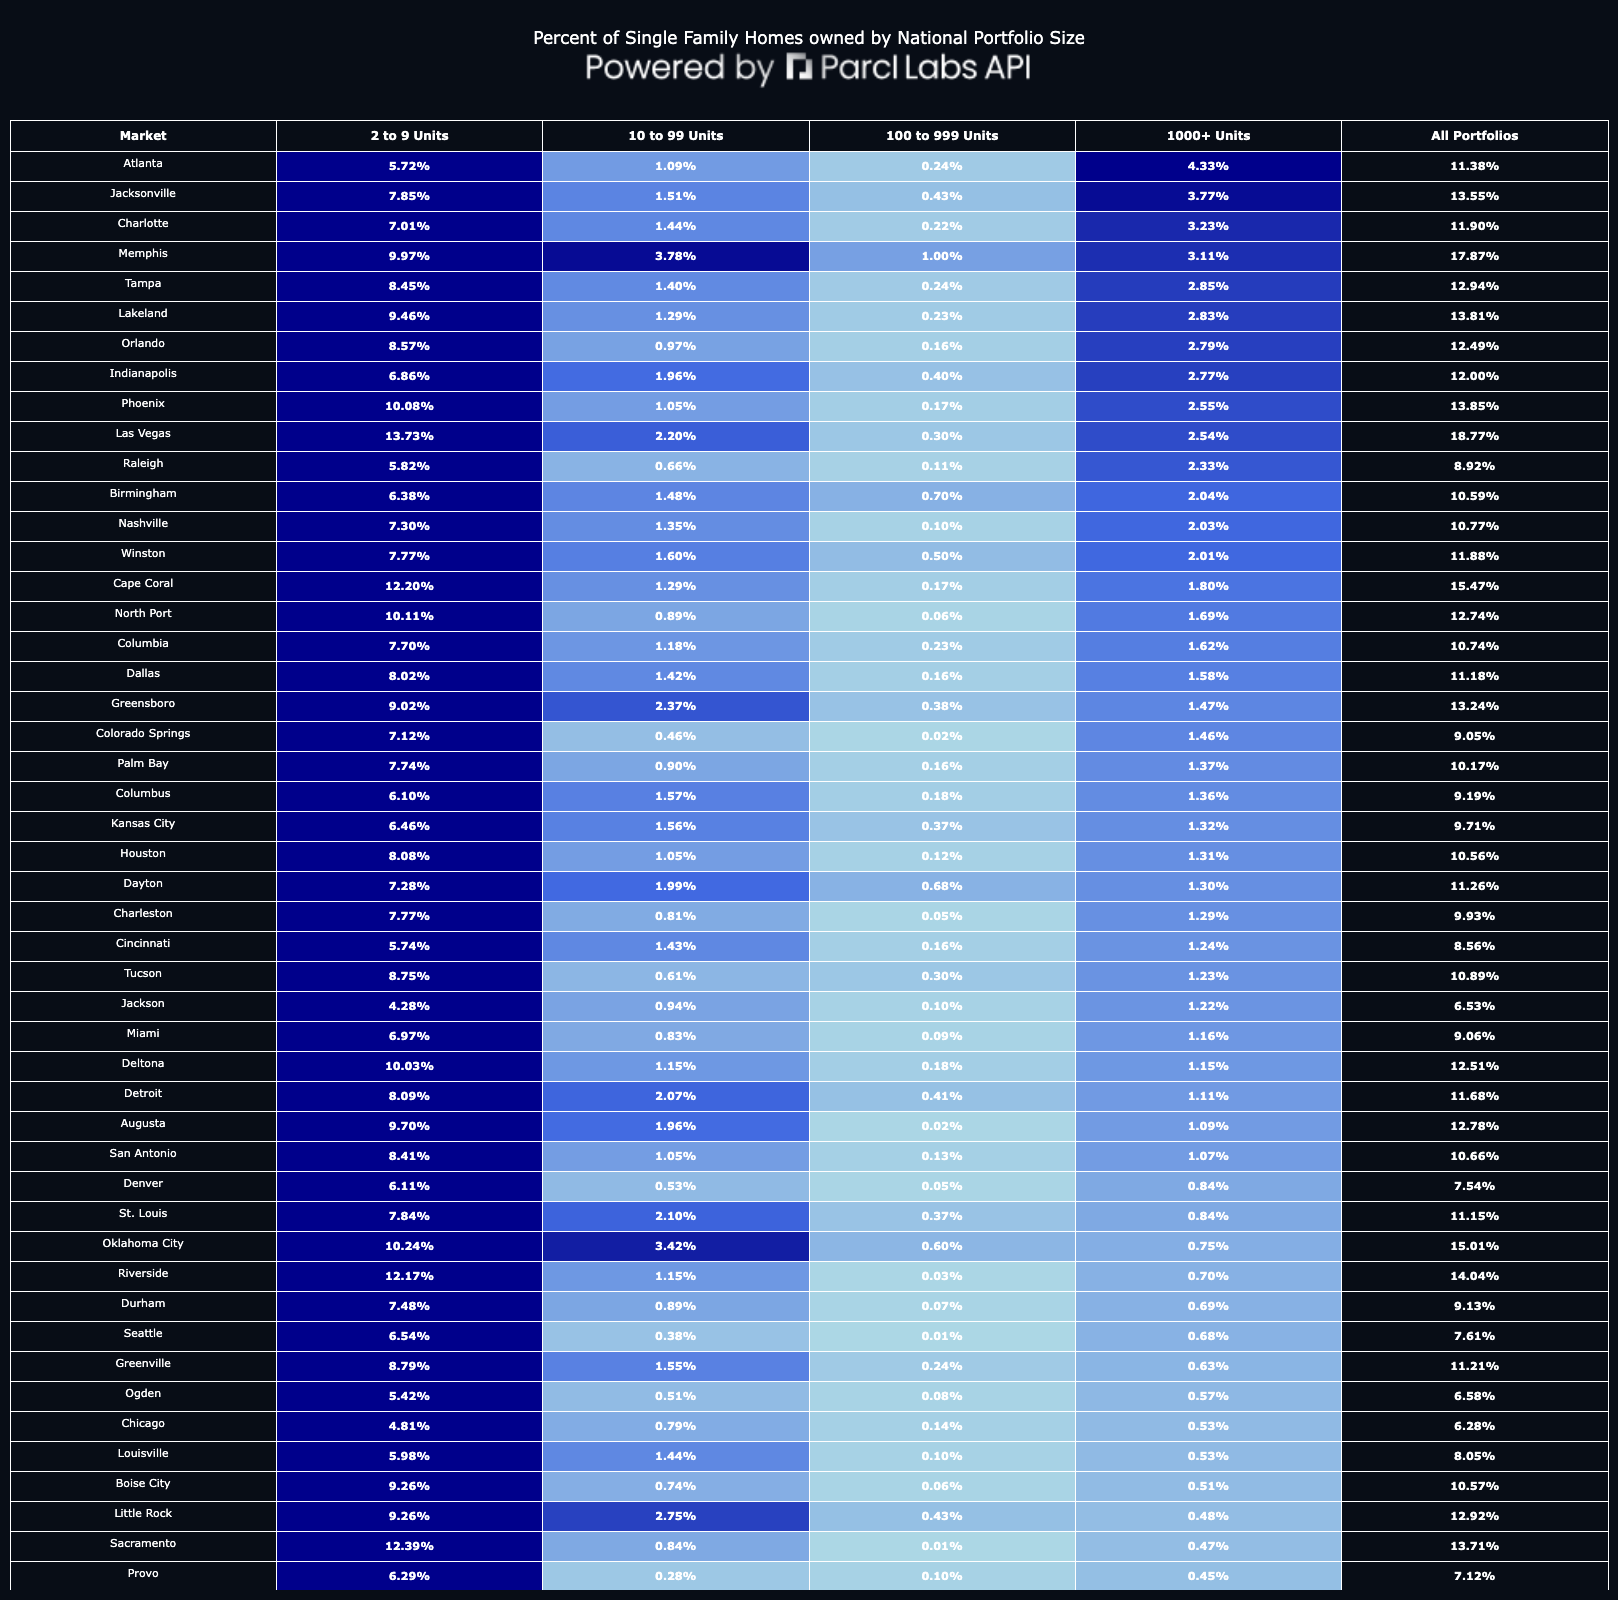

In [146]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Assuming charting_data is already defined and contains the necessary columns

# Define the function to scale the color based on the value
def color_scale(value):
    if value < 2:
        normalized = value / 2
        r = int(173 + (65 - 173) * normalized)
        g = int(216 + (105 - 216) * normalized)
        b = int(230 + (225 - 230) * normalized)
    elif value < 4:
        normalized = (value - 2) / 2
        r = int(65 + (0 - 65) * normalized)
        g = int(105 + (0 - 105) * normalized)
        b = int(225 + (139 - 225) * normalized)
    else:
        r, g, b = 0, 0, 139
    r = max(0, min(255, r))
    g = max(0, min(255, g))
    b = max(0, min(255, b))
    return f'rgb({r},{g},{b})'

# Prepare data and colors for the table
colors = [[] for _ in range(len(charting_data.columns))]
formatted_data = []

for i, col in enumerate(charting_data.columns):
    formatted_column = []
    color_column = []
    for value in charting_data[col]:
        # Formatting all values as bold percentages
        formatted_column.append(f"<b>{value:.2f}%</b>")
        # Apply color scale only to columns other than 'All Portfolios'
        if col != 'pct_sf_housing_stock_all_portfolios':
            color_column.append(color_scale(value))
        else:
            color_column.append("#080D16")  # Set 'All Portfolios' background to match the main background color
    formatted_data.append(formatted_column)
    colors[i] = color_column

# Define headers and table layout
column_headers = ['2 to 9 Units', '10 to 99 Units', '100 to 999 Units', '1000+ Units', 'All Portfolios']

fig = go.Figure(data=[go.Table(
    header=dict(values=['<b>Market</b>'] + [f"<b>{header}</b>" for header in column_headers],
                fill_color='#080D16',
                font=dict(color='#FFFFFF', size=12),
                align='center',
                height=30),
    cells=dict(values=[charting_data.index.tolist()] + formatted_data,
               fill=dict(color=[['#080D16']*len(charting_data)] + colors),
               font=dict(color='#FFFFFF', size=11),
               align='center',
               height=30)
)])

# Add the logo image
labs_logo_lookup = {
    'blue': 'https://parcllabs-assets.s3.amazonaws.com/powered-by-parcllabs-api.png',
    'white': 'https://parcllabs-assets.s3.amazonaws.com/powered-by-parcllabs-api-logo-white+(1).svg'
}
labs_logo_dict = dict(
    source=labs_logo_lookup['white'],
    xref="paper",
    yref="paper",
    x=0.5,
    y=1.01,
    sizex=0.3,
    sizey=0.2,
    xanchor="center",
    yanchor="bottom"
)
fig.add_layout_image(labs_logo_dict)

# Update layout and display the figure
fig.update_layout(
    title={
        'text': 'Percent of Single Family Homes owned by National Portfolio Size',
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    title_font_color='#FFFFFF',
    width=850,
    height=1600,
    paper_bgcolor='#080D16',
    margin=dict(l=10, r=10, t=120, b=10)
)
fig.show()


In [151]:
out.head()

,pct_sf_housing_stock_portfolio_2_to_9,pct_sf_housing_stock_portfolio_10_to_99,pct_sf_housing_stock_portfolio_100_to_999,pct_sf_housing_stock_portfolio_1000_plus,pct_sf_housing_stock_all_portfolios
name,,,,,
New York,4.85,0.26,0.04,0.07,5.22
Los Angeles,9.76,0.53,0.04,0.22,10.55
Chicago,4.81,0.79,0.14,0.53,6.28
Dallas,8.02,1.42,0.16,1.58,11.18
Houston,8.08,1.05,0.12,1.31,10.56


In [167]:

for index, row in out.sort_values('pct_sf_housing_stock_portfolio_2_to_9', ascending=False).head(20).iterrows():
    name = index
    institution = row['pct_sf_housing_stock_portfolio_1000_plus']
    mom = row['pct_sf_housing_stock_portfolio_2_to_9']
    print(f"{name}: {mom}% Owned")

Las Vegas: 13.73% Owned
Stockton: 13.52% Owned
Sacramento: 12.39% Owned
Fresno: 12.36% Owned
Cape Coral: 12.2% Owned
Riverside: 12.17% Owned
Bakersfield: 11.96% Owned
San Jose: 11.06% Owned
Oklahoma City: 10.24% Owned
San Francisco: 10.17% Owned
North Port: 10.11% Owned
Phoenix: 10.08% Owned
Oxnard: 10.07% Owned
Deltona: 10.03% Owned
Memphis: 9.97% Owned
Austin: 9.9% Owned
Los Angeles: 9.76% Owned
San Diego: 9.74% Owned
Augusta: 9.7% Owned
Toledo: 9.49% Owned
